In [615]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve 
from sklearn.model_selection import train_test_split

LABELS = ['False', 'True']

# Importing Data from file

In [616]:
# read data from csv file
# dataset_url = https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv
shopper_intention_filename = 'online_shoppers_intention.csv'
shopper_intention_data = pd.read_csv(shopper_intention_filename)

In [617]:
shopper_intention_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# 1. Feature Engineering
### 1.1 Feature Transformation

In [618]:
# Selecting categorical features
categorical_features = ['VisitorType','Month']

# How many labels does each CATEGORICAL variable/feature have ?
for feature in categorical_features:
    print(feature, ":", len(shopper_intention_data[feature].unique()), "labels")
    print(shopper_intention_data[feature].unique())

VisitorType : 3 labels
['Returning_Visitor' 'New_Visitor' 'Other']
Month : 10 labels
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']


In [619]:
# One-Hot-Encoding NOMINAL Categorical variables
categorical_features = ['VisitorType','Month']

dummies_0 = pd.get_dummies(shopper_intention_data[categorical_features[0]])
dummies_1 = pd.get_dummies(shopper_intention_data[categorical_features[1]])
encoded_data = pd.concat([shopper_intention_data, dummies_0], axis="columns")
encoded_data = pd.concat([encoded_data, dummies_1], axis="columns")

# Drop columns which have been encoded
final_encoded_data = encoded_data.drop(['VisitorType','Month'], axis = "columns")

In [620]:
# feature columns
feature_cols = [c for c in final_encoded_data.columns if c not in ['Revenue']]

X = final_encoded_data.loc[:,feature_cols]
y = final_encoded_data.loc[:,["Revenue"]]

# seggregate dataset into Training(70%) and Validation(30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# feature_cols
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8631, 28), (3699, 28), (8631, 1), (3699, 1))

### 1.2 Feature Selection with help of correlation

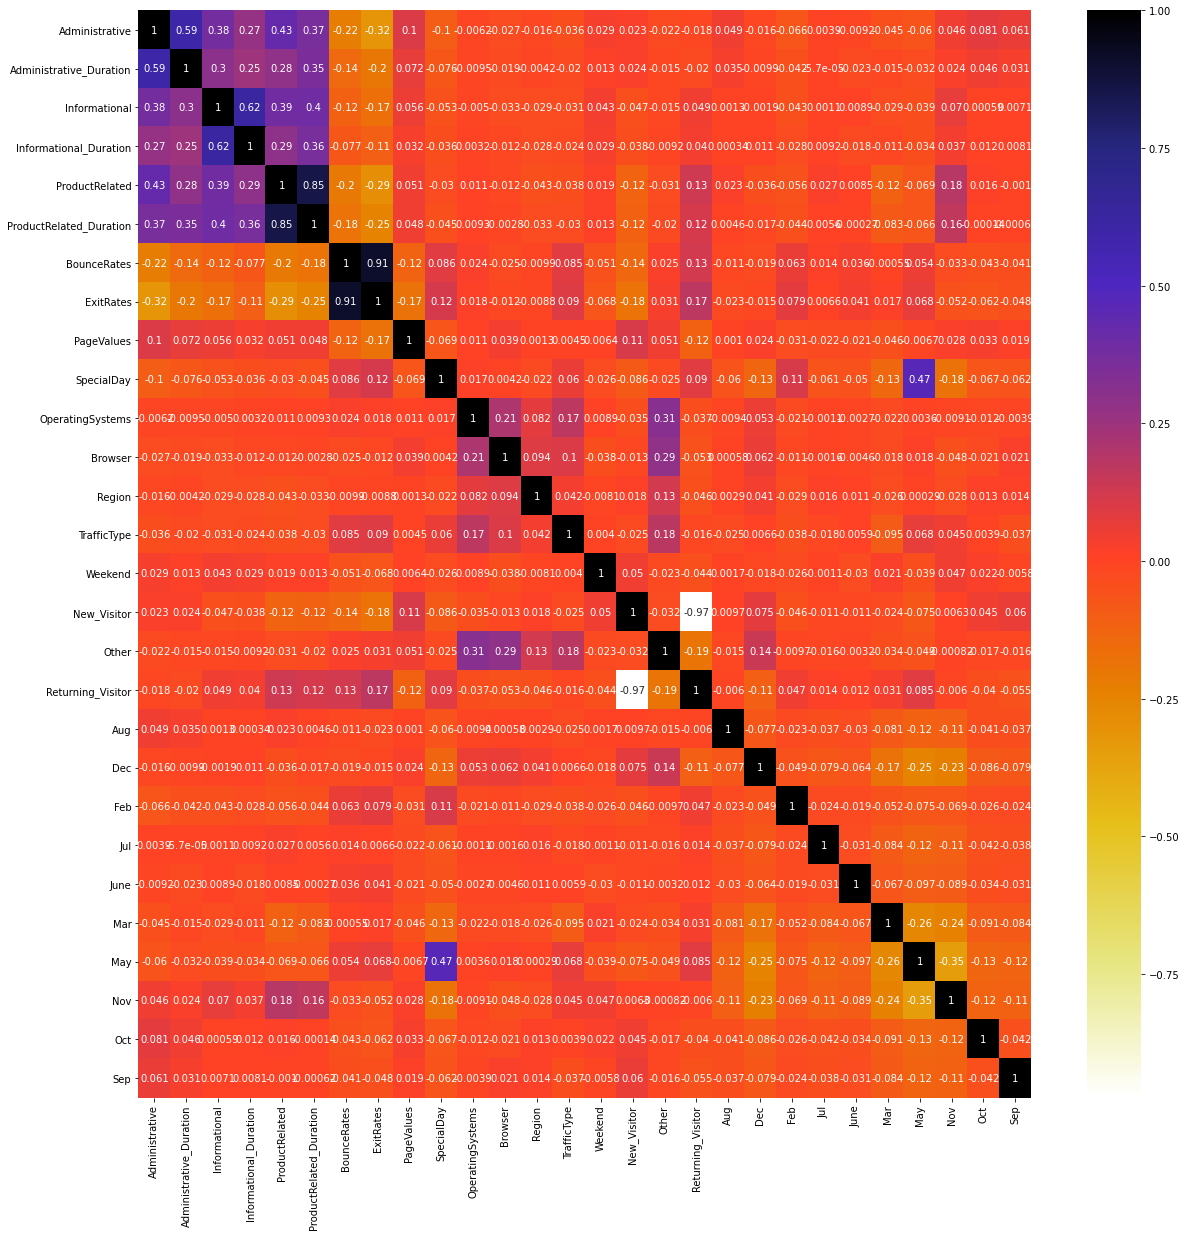

In [621]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = X_train.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [622]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with any other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [623]:
corr_features = correlation(X_train, 0.8)  # selecting features having correlation > 80% (absolute)
len(set(corr_features))

3

In [624]:
print("Highly Correlated Features: {}".format(corr_features))

Highly Correlated Features: {'Returning_Visitor', 'ProductRelated_Duration', 'ExitRates'}


In [625]:
# Drop correlated features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
7168,12,203.280000,4,241.7,47,1975.125,0.003636,0.015186,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
6818,0,0.000000,0,0.0,10,204.600,0.000000,0.020000,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4094,1,0.000000,0,0.0,1,0.000,0.200000,0.200000,0.0,0.6,...,0,0,0,0,0,0,1,0,0,0
3644,3,120.666667,0,0.0,8,261.600,0.000000,0.010000,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
7288,0,0.000000,0,0.0,1,0.000,0.200000,0.200000,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


# 2. Constructing and training model
### 2.1 Decision Tree

In [626]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
# class weight has to be provided as number of positives and negatives is not equal.
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

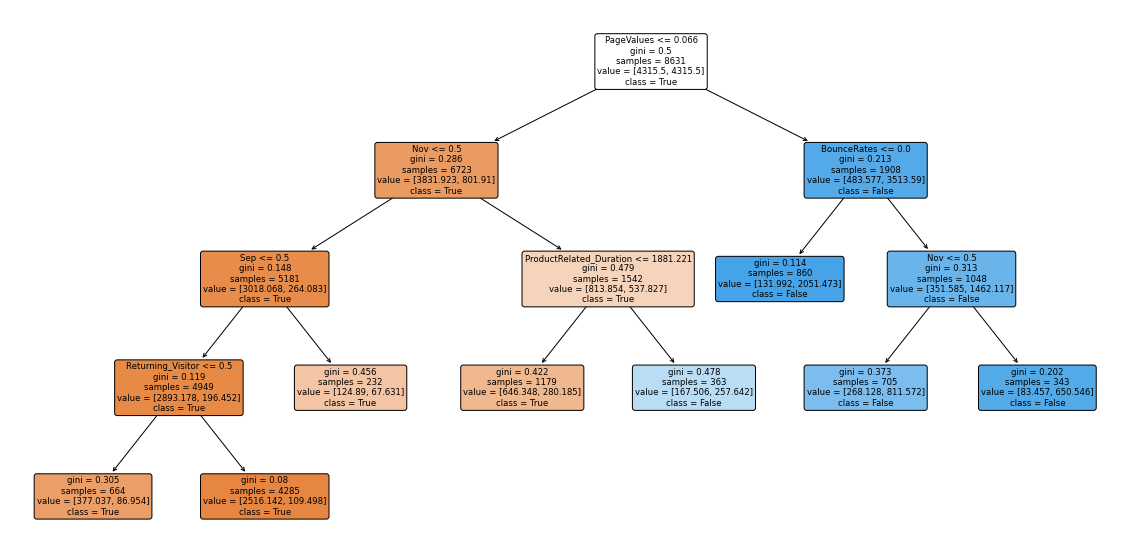

In [627]:
# visualize decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dtc, 
          feature_names = feature_cols,
          class_names = ['True', 'False'],
          rounded = True,
          filled = True)
plt.show()

In [628]:
# Predictions from Decision tree
y_train_predict_dtc = dtc.predict(X_train)
y_test_predict_dtc = dtc.predict(X_test)

### 2.2 Random Forest

In [629]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train.values.ravel()) 

# Predictions from Random Forest Learner
y_train_predict_rfc = rfc.predict(X_train)
y_test_predict_rfc = rfc.predict(X_test)

### 2.3 Support Vector Machine

In [630]:
from sklearn.svm import SVC

svm = SVC(C=100)
svm.fit(X_train, y_train.values.ravel())

# Predictions from SVM
y_train_predict_svm = svm.predict(X_train)
y_test_predict_svm = svm.predict(X_test)

### 2.4 K Nearest Neighbour

In [631]:
# Scaling the features for KNN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(final_encoded_data.drop(["Revenue"], axis='columns'))
scaled_features = scaler.transform(final_encoded_data.drop(["Revenue"], axis='columns'))
scaled_features
scaled_data = pd.DataFrame(scaled_features,columns=feature_cols)
scaled_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,-0.190777,-0.403582,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,-0.190777,-0.403582,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,-0.190777,-0.403582,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,-0.190777,-0.403582,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,-0.190777,-0.403582,8.124707,-0.190548,-0.154649,-0.427739,-0.612532,-0.566798,-0.215871,-0.194175


In [632]:
# Splitting scaled data
X_train, X_test, y_train, y_test = train_test_split(scaled_features,final_encoded_data['Revenue'], test_size=0.30)

In [633]:
# K nearest neighbour classification
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

y_test_predict_knn = knn.predict(X_test)

# 3. Confusion Matrices (Imbalanced Dataset)
### 3.1 Decision tree 

In [634]:
from sklearn.metrics import confusion_matrix, classification_report
cm_dtc = confusion_matrix(y_test, y_test_predict_dtc)

"""
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,5))
sn.heatmap(cm_dtc, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
"""

print(cm_dtc)

print("\n F1- Score: ", round(metrics.f1_score(y_test, y_test_predict_dtc), 2))
print("\n Accuracy: ", round(accuracy_score(y_test, y_test_predict_dtc), 2))

[[2290  822]
 [ 436  151]]

 F1- Score:  0.19

 Accuracy:  0.66


### 3.2 Random Forest Learner

In [635]:
cm_rfc = confusion_matrix(y_test, y_test_predict_rfc)

print(cm_rfc)

print("\n F1- Score: ", round(metrics.f1_score(y_test, y_test_predict_rfc), 2))
print("\n Accuracy: ", round(accuracy_score(y_test, y_test_predict_rfc), 2))

[[2737  375]
 [ 517   70]]

 F1- Score:  0.14

 Accuracy:  0.76


### 3.3 Support Vector Machine

In [636]:
cm_svm = confusion_matrix(y_test, y_test_predict_svm)

print(cm_svm)

print("\n F1- Score: ", round(metrics.f1_score(y_test, y_test_predict_svm), 2))
print("\n Accuracy: ", round(accuracy_score(y_test, y_test_predict_svm), 2))

[[2858  254]
 [ 548   39]]

 F1- Score:  0.09

 Accuracy:  0.78


### 3.4 K Nearest Neighbours

In [637]:
cm_knn = confusion_matrix(y_test, y_test_predict_knn)

print(cm_knn)

print("\n F1- Score: ", round(metrics.f1_score(y_test, y_test_predict_knn), 2))
print("\n Accuracy: ", round(accuracy_score(y_test, y_test_predict_knn), 2))

[[3065   47]
 [ 406  181]]

 F1- Score:  0.44

 Accuracy:  0.88


# 4. Plotting ROC curves

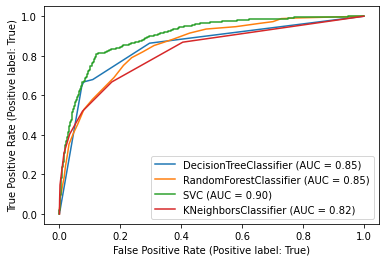

In [638]:
canvas = plot_roc_curve(dtc, X_test, y_test)
plot_roc_curve(rfc, X_test, y_test, ax=canvas.ax_);
plot_roc_curve(svm, X_test, y_test, ax=canvas.ax_);
plot_roc_curve(knn, X_test, y_test, ax=canvas.ax_);

##### Various metric scores for Decision Tree

In [639]:
print(classification_report(y_test, y_test_predict_dtc))

              precision    recall  f1-score   support

       False       0.84      0.74      0.78      3112
        True       0.16      0.26      0.19       587

    accuracy                           0.66      3699
   macro avg       0.50      0.50      0.49      3699
weighted avg       0.73      0.66      0.69      3699



##### Various metric scores for Random Forest Learner

In [640]:
print(classification_report(y_test, y_test_predict_rfc))

              precision    recall  f1-score   support

       False       0.84      0.88      0.86      3112
        True       0.16      0.12      0.14       587

    accuracy                           0.76      3699
   macro avg       0.50      0.50      0.50      3699
weighted avg       0.73      0.76      0.74      3699



###### Metric scores for Support Vector machine

In [641]:
print(classification_report(y_test, y_test_predict_svm))

              precision    recall  f1-score   support

       False       0.84      0.92      0.88      3112
        True       0.13      0.07      0.09       587

    accuracy                           0.78      3699
   macro avg       0.49      0.49      0.48      3699
weighted avg       0.73      0.78      0.75      3699



###### Metric scores for KNN

In [642]:
print(classification_report(y_test, y_test_predict_knn))

              precision    recall  f1-score   support

       False       0.88      0.98      0.93      3112
        True       0.79      0.31      0.44       587

    accuracy                           0.88      3699
   macro avg       0.84      0.65      0.69      3699
weighted avg       0.87      0.88      0.85      3699



# 5. Handling Imbalanced Dataset

Revenue-True: (1908, 18)
Revenue-False: (10422, 18)


Text(0, 0.5, 'Frequency')

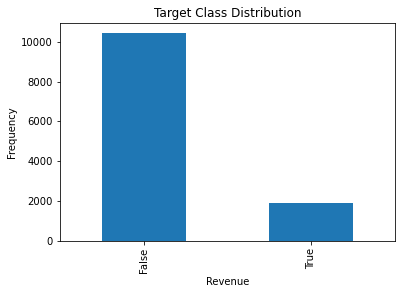

In [643]:
# count classes to determine minority and majority
count_classes = pd.value_counts(shopper_intention_data['Revenue'], sort = True)
revenue_true = shopper_intention_data[shopper_intention_data['Revenue'] == True]
revenue_false = shopper_intention_data[shopper_intention_data['Revenue'] == False]
print('Revenue-True: {}\nRevenue-False: {}'.format(revenue_true.shape , revenue_false.shape))
count_classes.plot(kind = 'bar')
plt.title("Target Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Revenue")
plt.ylabel("Frequency")

### 5.1 Oversampling Minority class in Training data

In [644]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os =  RandomOverSampler()
X_os, y_os = os.fit_resample(X, y)

print("Class Distribution Before Oversampling: \n", y.value_counts(),"\n")
print("Class Distribution After Oversampling: \n", y_os.value_counts())

Class Distribution Before Oversampling: 
 Revenue
False      10422
True        1908
dtype: int64 

Class Distribution After Oversampling: 
 Revenue
False      10422
True       10422
dtype: int64


In [645]:
# seggregate dataset into Training(70%) and Validation(30%) sets
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.3)
# feature_cols
X_train_os.shape, X_test_os.shape, y_train_os.shape, y_test_os.shape

((14590, 28), (6254, 28), (14590, 1), (6254, 1))

### 5.1.1 Decision Tree

In [646]:
# Decision tree for over-sampled data
dtc_os = DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
dtc_os.fit(X_train_os, y_train_os)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

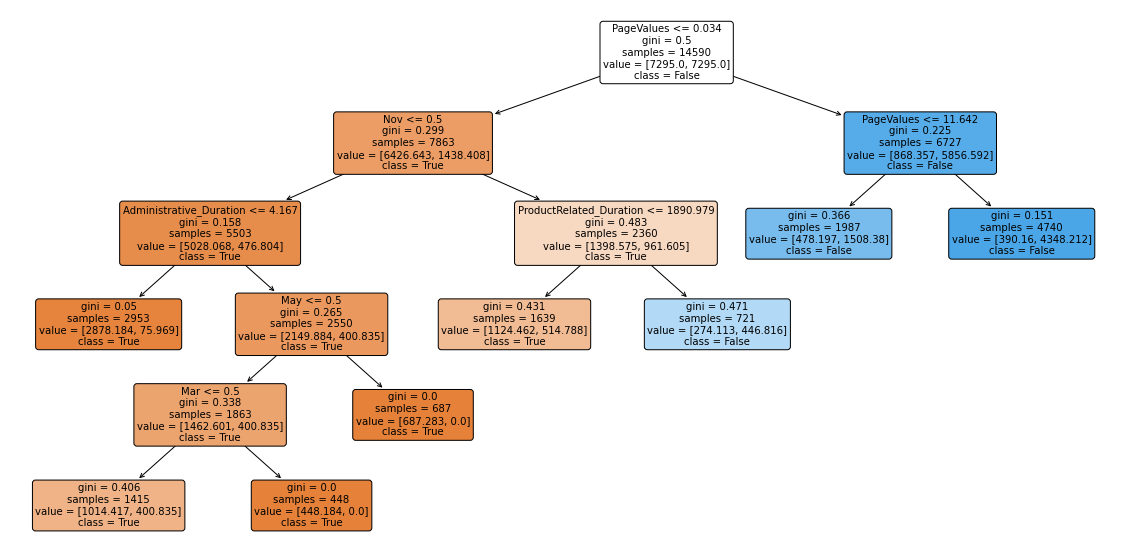

In [647]:
# visualize decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dtc_os, 
          feature_names = feature_cols,
          class_names = ['True', 'False'],
          rounded = True,
          filled = True)
plt.show()

In [648]:
# Predictions from Decision tree
y_train_predict_dtc = dtc_os.predict(X_train_os)
y_test_predict_dtc_os = dtc_os.predict(X_test_os)

In [649]:
# Plot Confusion Matrix for Decision Tree Classifier
from sklearn.metrics import confusion_matrix, classification_report
cm_dtc_os = confusion_matrix(y_test_os, y_test_predict_dtc_os)
""" 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
"""
print(cm_dtc_os)

print("\n F1- Score: ", round(metrics.f1_score(y_test_os, y_test_predict_dtc_os), 3))

# Various metric scores for Decision Tree
print(classification_report(y_test_os, y_test_predict_dtc_os))

[[2680  450]
 [ 426 2698]]

 F1- Score:  0.86
              precision    recall  f1-score   support

       False       0.86      0.86      0.86      3130
        True       0.86      0.86      0.86      3124

    accuracy                           0.86      6254
   macro avg       0.86      0.86      0.86      6254
weighted avg       0.86      0.86      0.86      6254



### 5.1.2 Random Forest Learner

In [650]:
from sklearn.ensemble import RandomForestClassifier

rfc_os = RandomForestClassifier(n_estimators=50)
rfc_os.fit(X_train_os, y_train_os.values.ravel()) # 

# Predictions from Random Forest Learner
y_train_predict_rfc_os = rfc_os.predict(X_train_os)
y_test_predict_rfc_os = rfc_os.predict(X_test_os)

In [651]:
# Confusion Matrix for Random Forest Learner (Oversampled)
cm_rfc_os = confusion_matrix(y_test_os, y_test_predict_rfc_os)
print(cm_rfc_os)

print("\n F1- Score: ", round(metrics.f1_score(y_test_os, y_test_predict_rfc_os), 3),"\n")

# Various metric scores for Random Forest Learner 
print(classification_report(y_test_os, y_test_predict_rfc_os))

[[2916  214]
 [  33 3091]]

 F1- Score:  0.962 

              precision    recall  f1-score   support

       False       0.99      0.93      0.96      3130
        True       0.94      0.99      0.96      3124

    accuracy                           0.96      6254
   macro avg       0.96      0.96      0.96      6254
weighted avg       0.96      0.96      0.96      6254



### 5.1.3 Support Vector machine

In [652]:
from sklearn.svm import SVC

svm_os = SVC(C=100)
svm_os.fit(X_train_os, y_train_os.values.ravel())

# Predictions from SVM
y_train_predict_svm_os = svm_os.predict(X_train_os)
y_test_predict_svm_os = svm_os.predict(X_test_os)

In [653]:
cm_svm_os = confusion_matrix(y_test_os, y_test_predict_svm_os)

print(cm_svm_os)

print("\n F1- Score: ", round(metrics.f1_score(y_test_os, y_test_predict_svm_os), 2))

# Various metric scores for SVM
print(classification_report(y_test_os, y_test_predict_svm_os))

[[2756  374]
 [ 760 2364]]

 F1- Score:  0.81
              precision    recall  f1-score   support

       False       0.78      0.88      0.83      3130
        True       0.86      0.76      0.81      3124

    accuracy                           0.82      6254
   macro avg       0.82      0.82      0.82      6254
weighted avg       0.82      0.82      0.82      6254



### 5.1.4 K-Nearest Neighbours

In [654]:
# Scaling the features for KNN
scaler = StandardScaler()
scaler.fit(X_os)
scaled_features_os = scaler.transform(X_os)
scaled_data_os = pd.DataFrame(scaled_features_os ,columns=feature_cols)
scaled_data_os.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
0,-0.775212,-0.511962,-0.445581,-0.280866,-0.736856,-0.701980,4.719902,4.099601,-0.510405,-0.26357,...,-0.195984,-0.381232,10.185466,-0.192661,-0.142878,-0.391809,-0.563166,-0.667077,-0.230087,-0.200558
1,-0.775212,-0.511962,-0.445581,-0.280866,-0.717156,-0.671399,-0.390473,1.637133,-0.510405,-0.26357,...,-0.195984,-0.381232,10.185466,-0.192661,-0.142878,-0.391809,-0.563166,-0.667077,-0.230087,-0.200558
2,-0.775212,-0.511962,-0.445581,-0.280866,-0.736856,-0.701980,4.719902,4.099601,-0.510405,-0.26357,...,-0.195984,-0.381232,10.185466,-0.192661,-0.142878,-0.391809,-0.563166,-0.667077,-0.230087,-0.200558
3,-0.775212,-0.511962,-0.445581,-0.280866,-0.717156,-0.700706,0.887120,2.622120,-0.510405,-0.26357,...,-0.195984,-0.381232,10.185466,-0.192661,-0.142878,-0.391809,-0.563166,-0.667077,-0.230087,-0.200558
4,-0.775212,-0.511962,-0.445581,-0.280866,-0.559555,-0.402135,0.120564,0.405899,-0.510405,-0.26357,...,-0.195984,-0.381232,10.185466,-0.192661,-0.142878,-0.391809,-0.563166,-0.667077,-0.230087,-0.200558


In [655]:
# Splitting scaled data
X_train_knn_os, X_test_knn_os, y_train_knn_os, y_test_knn_os = train_test_split(scaled_features_os , y_os, test_size=0.30)


In [656]:
from sklearn.neighbors import KNeighborsClassifier

knn_os = KNeighborsClassifier(n_neighbors=44)
knn_os.fit(X_train_knn_os, y_train_knn_os.values.ravel())

y_test_predict_knn_os = knn.predict(X_test_knn_os)

## Confusion Matrix
cm_knn_os = confusion_matrix(y_test_knn_os, y_test_predict_knn_os)
print(cm_knn_os)

print("\n F1- Score: ", round(metrics.f1_score(y_test_knn_os, y_test_predict_knn_os), 2))

# Various metric scores for KNN
print(classification_report(y_test_knn_os, y_test_predict_knn_os))

[[3107   25]
 [2568  554]]

 F1- Score:  0.3
              precision    recall  f1-score   support

       False       0.55      0.99      0.71      3132
        True       0.96      0.18      0.30      3122

    accuracy                           0.59      6254
   macro avg       0.75      0.58      0.50      6254
weighted avg       0.75      0.59      0.50      6254



### 5.1.5 Plotting ROC curves for Oversampled minority class

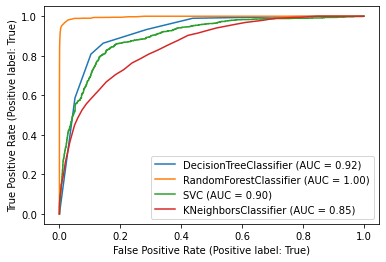

In [657]:
canvas = plot_roc_curve(dtc_os, X_test_os, y_test_os)
plot_roc_curve(rfc_os, X_test_os, y_test_os, ax=canvas.ax_);
plot_roc_curve(svm_os, X_test_os, y_test_os, ax=canvas.ax_);
plot_roc_curve(knn_os, X_test_knn_os, y_test_knn_os, ax=canvas.ax_);

### 5.2 Undersampling Majority class in Training data

In [658]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
X_us,y_us=nm.fit_resample(X,y)

print("Class Distribution Before Oversampling: \n", y.value_counts(),"\n")
print("Class Distribution After Oversampling: \n", y_us.value_counts())

Class Distribution Before Oversampling: 
 Revenue
False      10422
True        1908
dtype: int64 

Class Distribution After Oversampling: 
 Revenue
False      1908
True       1908
dtype: int64


In [659]:
# seggregate dataset into Training(70%) and Validation(30%) sets
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.3)

### 5.2.1 Decision Tree

In [660]:
# Decision tree for over-sampled data
dtc_us = DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
dtc_us.fit(X_train_us, y_train_us)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

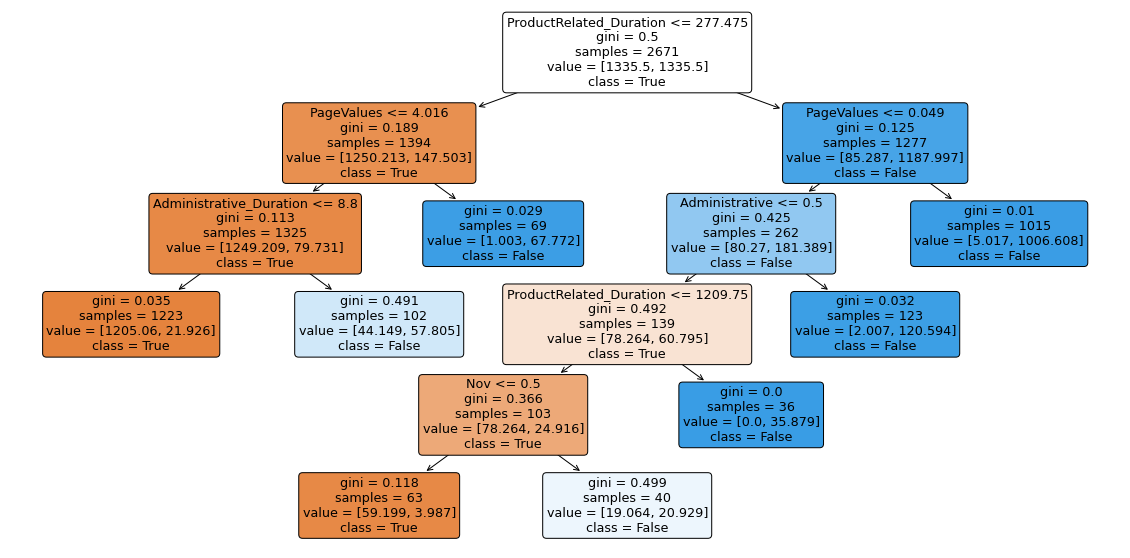

In [661]:
# visualize decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dtc_us, 
          feature_names = feature_cols,
          class_names = ['True', 'False'],
          rounded = True,
          filled = True)
plt.show()

In [662]:
# Predictions from Decision tree
y_train_predict_dtc = dtc_us.predict(X_train_us)
y_test_predict_dtc_us = dtc_us.predict(X_test_us)

In [663]:
# Plot Confusion Matrix for Decision Tree Classifier
from sklearn.metrics import confusion_matrix, classification_report
cm_dtc_us = confusion_matrix(y_test_us, y_test_predict_dtc_us)
""" 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
"""
print(cm_dtc_us)

print("\n F1- Score: ", round(metrics.f1_score(y_test_us, y_test_predict_dtc_us), 3),"\n")

# Various metric scores for Decision Tree Classifier 
print(classification_report(y_test_us, y_test_predict_dtc_us))

[[539  38]
 [ 11 557]]

 F1- Score:  0.958 

              precision    recall  f1-score   support

       False       0.98      0.93      0.96       577
        True       0.94      0.98      0.96       568

    accuracy                           0.96      1145
   macro avg       0.96      0.96      0.96      1145
weighted avg       0.96      0.96      0.96      1145



### 5.2.2 Random Forest Learner

In [664]:
from sklearn.ensemble import RandomForestClassifier

rfc_us = RandomForestClassifier(n_estimators=50)
rfc_us.fit(X_train_us, y_train_us.values.ravel()) # 

# Predictions from Random Forest Learner
y_train_predict_rfc_us = rfc_us.predict(X_train_us)
y_test_predict_rfc_us = rfc_us.predict(X_test_us)

In [665]:
# Confusion Matrix for Random Forest Learner (Oversampled)
cm_rfc_us = confusion_matrix(y_test_us, y_test_predict_rfc_us)
print(cm_rfc_us)

print("\n F1- Score: ", round(metrics.f1_score(y_test_us, y_test_predict_rfc_us), 3),"\n")

# Various metric scores for Random Forest Learner 
print(classification_report(y_test_us, y_test_predict_rfc_us))

[[562  15]
 [ 13 555]]

 F1- Score:  0.975 

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       577
        True       0.97      0.98      0.98       568

    accuracy                           0.98      1145
   macro avg       0.98      0.98      0.98      1145
weighted avg       0.98      0.98      0.98      1145



### 5.2.3 Support Vector Machines

In [666]:
from sklearn.svm import SVC

svm_us = SVC(C=100)
svm_us.fit(X_train_us, y_train_us.values.ravel())

# Predictions from SVM
y_train_predict_svm_us = svm_us.predict(X_train_us)
y_test_predict_svm_us = svm_us.predict(X_test_us)

In [672]:
cm_svm_us = confusion_matrix(y_test_us, y_test_predict_svm_us)

print(cm_svm_us)

print("\n F1- Score: ", round(metrics.f1_score(y_test_us, y_test_predict_svm_us), 2), "\n")

# Various metric scores for SVM
print(classification_report(y_test_us, y_test_predict_svm_us))

[[567  10]
 [ 28 540]]

 F1- Score:  0.97 

              precision    recall  f1-score   support

       False       0.95      0.98      0.97       577
        True       0.98      0.95      0.97       568

    accuracy                           0.97      1145
   macro avg       0.97      0.97      0.97      1145
weighted avg       0.97      0.97      0.97      1145



### 5.2.4 K Nearest neighbours

In [668]:
# Scaling the features for KNN
scaler = StandardScaler()
scaler.fit(X_us)
scaled_features_us = scaler.transform(X_us)
scaled_data_us = pd.DataFrame(scaled_features_us ,columns=feature_cols)
scaled_data_us.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
0,0.713988,-0.085537,-0.348361,-0.231049,-0.528008,-0.514914,-0.589846,-0.368502,-0.481905,-0.288961,...,-0.177849,2.636285,-0.147264,-0.1825,-0.150027,-0.42551,-0.58663,-0.637621,-0.204375,-0.174688
1,-0.244470,-0.254645,-0.348361,-0.231049,-0.570869,-0.527918,0.075844,0.487133,-0.481905,-0.288961,...,-0.177849,-0.379322,-0.147264,-0.1825,-0.150027,-0.42551,-0.58663,-0.637621,4.892972,-0.174688
2,0.075016,-0.220239,-0.348361,-0.231049,-0.570869,-0.527918,-0.589846,0.487133,-0.481905,-0.288961,...,-0.177849,2.636285,-0.147264,-0.1825,-0.150027,-0.42551,-0.58663,-0.637621,-0.204375,-0.174688
3,0.075016,-0.241662,-0.348361,-0.231049,-0.506577,-0.527918,0.475258,0.772345,-0.481905,-0.288961,...,5.622756,-0.379322,-0.147264,-0.1825,-0.150027,-0.42551,-0.58663,-0.637621,-0.204375,-0.174688
4,-0.563957,-0.392269,-0.348361,-0.231049,-0.506577,-0.527918,2.072915,1.913191,-0.481905,-0.288961,...,-0.177849,-0.379322,-0.147264,-0.1825,-0.150027,-0.42551,-0.58663,1.568329,-0.204375,-0.174688


In [669]:
# Splitting scaled data
X_train_knn_us, X_test_knn_us, y_train_knn_us, y_test_knn_us = train_test_split(scaled_features_us , y_us, test_size=0.30)
X_train_knn_us.shape, X_test_knn_us.shape, y_train_knn_us.shape, y_test_knn_us.shape

((2671, 28), (1145, 28), (2671, 1), (1145, 1))

In [670]:
from sklearn.neighbors import KNeighborsClassifier

knn_us = KNeighborsClassifier(n_neighbors=44)
knn_us.fit(X_train_knn_us, y_train_knn_us)

y_test_predict_knn_us = knn.predict(X_test_knn_us)

# Confusion Matrix
cm_knn_us = confusion_matrix(y_test_knn_us, y_test_predict_knn_us)
print(cm_knn_us)

print("\n F1- Score: ", round(metrics.f1_score(y_test_knn_us, y_test_predict_knn_us), 2))

# Various metric scores for KNN
print(classification_report(y_test_knn_us, y_test_predict_knn_us))

/Users/deepankkartikey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[572   0]
 [448 125]]

 F1- Score:  0.36
              precision    recall  f1-score   support

       False       0.56      1.00      0.72       572
        True       1.00      0.22      0.36       573

    accuracy                           0.61      1145
   macro avg       0.78      0.61      0.54      1145
weighted avg       0.78      0.61      0.54      1145



### 5.2.5 Plotting ROC curves for Undersampling majority class

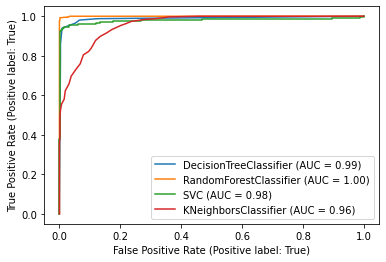

In [674]:
canvas = plot_roc_curve(dtc_us, X_test_us, y_test_us)
plot_roc_curve(rfc_os, X_test_us, y_test_us, ax=canvas.ax_);
plot_roc_curve(svm_os, X_test_us, y_test_us, ax=canvas.ax_);
plot_roc_curve(knn_os, X_test_knn_us, y_test_knn_us, ax=canvas.ax_);